In [3]:
import pandas as pd
import numpy as np
import json
import re
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from surprise import Reader, Dataset, SVD ,KNNWithMeans
from surprise.model_selection import cross_validate ,GridSearchCV , train_test_split


In [ ]:
steam_df = pd.read_csv('./data/steam-200k.csv', header=None, index_col=None, names=['UserID', 'Game', 'Action', 'Hours', 'Other'])

In [ ]:
steam_df.head(15)

In [ ]:
steam_df.value_counts()

In [ ]:
def parse(path):
    data = []
    g = gzip.open(path, 'r')
    for l in g:
        data.append(eval(l))
    return data

In [ ]:
play_data = steam_df[steam_df['Action'] == 'play']

In [ ]:
play_data_new = play_data.drop(['Action', 'Other'], axis=1)

In [ ]:
nb_games = 10
df_purchase = steam_df.loc[steam_df['Action'] == 'purchase']
purchased_times = df_purchase.groupby('Game')['Game'].agg('count').sort_values(ascending=False)
purchased_times = pd.DataFrame({'game': purchased_times.index, 'times_purchased': purchased_times.values})[0:nb_games]

play_data = steam_df[steam_df['Action'] == 'play']
hours_played = play_data.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_games]

fig, ax = plt.subplots(1,2,figsize=(12,nb_games))

sns.barplot(y = 'game', x = 'times_purchased', data = purchased_times, ax=ax[0])
sns.barplot(y = 'game', x = 'hours_played', data = hours_played, ax=ax[1])


ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
for i in range(0,2):
    ax[i].tick_params(axis='y', labelsize=18)
    ax[i].xaxis.label.set_size(20)

In [ ]:
play_data_new

In [ ]:
# # Define the function to categorize hours
# def categorize_hours(hours):
#     if hours <= 20:
#         return 1
#     elif 21 <= hours <= 100:
#         return 2
#     elif 101 <= hours <= 500:
#         return 3
#     elif 501 <= hours <= 1000:
#         return 4
#     else:
#         return 5

# # Apply the function to the 'Hours' column to create a new 'Reviews' column
# play_data_new['Ratings'] = play_data_new['Hours'].apply(categorize_hours)

In [ ]:
game_hours_min_max = play_data_new.groupby('Game')['Hours'].agg(['min', 'max']).reset_index()

In [ ]:
# Define a new function for cumulative hours to fit the rating system
# Recalculate the total hours played for each game across all users
# Create a DataFrame for the rating of each game
game_hours_min_max.columns = ['Game', 'Min_Hours', 'Max_Hours']

# Merge this with the original play_data_new DataFrame
play_data_agg_min_max = play_data_new.merge(game_hours_min_max, on='Game')

play_data_agg_min_max.head()


In [ ]:
play_data_agg_min_max.tail(50)

In [ ]:
filtered_data_new = play_data_agg_min_max.loc[play_data_agg_min_max['Min_Hours'] != play_data_agg_min_max['Max_Hours']]

In [ ]:
filtered_data_new

In [ ]:
def ratings_normalize(d):
    new_series = d['Hours'] / d['Max_Hours']
    return new_series

In [ ]:
filtered_data['Hours']

In [ ]:
filtered_data['Ratings'] = filtered_data.apply(lambda x: (x["Hours"] / x["Max_Hours"]), axis=1)

In [ ]:
filtered_data

In [ ]:
filtered_data.to_csv('./data/cleaned_steam_games.csv')

In [ ]:
df = pd.read_csv('data/cleaned_steam_games.csv' ,index_col=0)

In [ ]:
df

In [ ]:
# Define the Reader
reader = Reader(rating_scale=(0, 1))

# Load the dataset into Surprise
data = Dataset.load_from_df(df[['UserID', 'Game', 'Ratings']], reader)

# SVD algo
algo_svd = SVD()

# Perform cross-validation
svd_results = cross_validate(algo_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
# Define the Reader
reader = Reader(rating_scale=(0, 1))

# Load the dataset into Surprise
data = Dataset.load_from_df(df[['UserID', 'Game', 'Ratings']], reader)

# Configure KNNWithMeans
algo_knnm = KNNWithMeans(sim_options={'name': 'cosine', 'user_based': True})

# Perform cross-validation
results_knnm = cross_validate(algo_knnm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
df.isna().sum()

In [ ]:
# Define the Reader
reader = Reader(rating_scale=(0, 1))

# Load the dataset into Surprise
data = Dataset.load_from_df(df[['UserID', 'Game', 'Ratings']], reader)

# Configure KNNWithMeans
algo_knnm = KNNWithMeans(sim_options={'name': 'cosine', 'user_based': True})

# Perform cross-validation
results_knnm = cross_validate(algo_knnm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
rmse = svd_results['test_rmse']
mae = svd_results['test_mae']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(rmse)
plt.title('RMSE')
plt.subplot(1, 2, 2)
plt.boxplot(mae)
plt.title('MAE')
plt.show()


In [ ]:
rmse = results_knnm['test_rmse']
mae = results_knnm['test_mae']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(rmse)
plt.title('RMSE')
plt.subplot(1, 2, 2)
plt.boxplot(mae)
plt.title('MAE')
plt.show()

In [ ]:
trainset = data.build_full_trainset()
algo_svd.fit(trainset)

In [ ]:
# # Make a prediction for a specific user and item
# user_id = '176449171'  # Replace with the actual user ID
# game_id = 'Counter-Strike Global Offensive'  # Replace with the actual item ID
# rating_prediction = algo.predict(user_id, game_id)
# print(f"The estimated rating for Game {game_id} by User {user_id} is {rating_prediction.est}")

In [ ]:
# param_grid = {'k': [20, 30, 40],  # Number of neighbors
#               'sim_options': {'name': ['cosine', 'msd', 'pearson']}
#              }

# grid_search = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=6)

# grid_search.fit(data)

In [ ]:
# # best RMSE score
# print(grid_search.best_score["rmse"])

# # combination of parameters that gave the best RMSE score
# print(grid_search.best_params["rmse"])

with the best params KNNwithMeans

In [ ]:
trainset, testset = train_test_split(data, test_size=0.2)

# Configure KNNWithMeans
algo_knnm_2 = KNNWithMeans(K=40 , sim_options={'name': 'msd', 'user_based': True})
algo_knnm_2.fit(trainset)

# Perform cross-validation
results_knnm_2 = cross_validate(algo_knnm_2, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
# To make predictions for a specific game
def predict_hours_for_game(algo, game, user_ids):
    predictions = []
    for user_id in user_ids:
        predictions.append(algo.predict(uid=user_id, iid=game))
    return predictions

# Example usage
game_of_interest = "Fallout 4"
predicted_hours = predict_hours_for_game(algo_svd, game_of_interest, user_ids=play_data['UserID'].unique())

# You can then sort these predictions based on the estimated hours
sorted_predictions = sorted(predicted_hours, key=lambda x: x.est, reverse=True)

# And recommend the game to top users
top_user_recommendations = sorted_predictions[:5]  # Top 5 users

In [ ]:
pd.DataFrame(top_user_recommendations)

In [ ]:
filtered_data.loc[filtered_data.Ratings>0.4]

In [ ]:
# To make predictions for a specific game
def predict_hours_for_game(algo, game, user_ids):
    predictions = []
    for user_id in user_ids:
        predictions.append(algo_knnm_2.predict(uid=user_id, iid=game))
    return predictions

# Example usage
game_of_interest = "The Elder Scrolls V Skyrim"
predicted_hours = predict_hours_for_game(algo_knnm_2, game_of_interest, user_ids=filtered_data['UserID'].unique())

# You can then sort these predictions based on the estimated hours
sorted_predictions = sorted(predicted_hours, key=lambda x: x.est, reverse=True)

# And recommend the game to top users
top_user_recommendations = sorted_predictions[:20]  # Top 5 users

In [ ]:
algo_knnm_2.predict(uid=user_id, iid=game_of_interest)

In [ ]:
filtered_data.info()

In [ ]:
pd.DataFrame(sorted_predictions).info()

In [7]:
filtered_data_new=pd.read_csv('./data/filtered_steam_games.csv' , index_col=0)

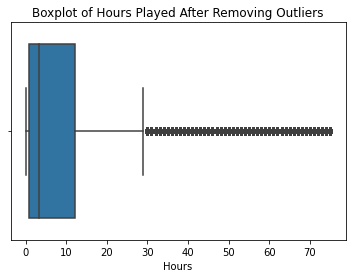

In [8]:
# Calculate IQR for 'Hours'
Q1 = filtered_data_new['Hours'].quantile(0.25)
Q3 = filtered_data_new['Hours'].quantile(0.75)
IQR = Q3 - Q1

# Define an upper bound for outliers
upper_bound = Q3 + 3 * IQR

# Removing outliers from 'Hours'
cleaned_dataset = filtered_data_new[filtered_data_new['Hours'] <= upper_bound]

# New basic statistics  after removing outliers
cleaned_numerical_stats = cleaned_dataset.describe()

# Plotting the new distribution of 'Hours'
plt.figure(figsize=(6, 4))
sns.boxplot(x=cleaned_dataset['Hours'])
plt.title('Boxplot of Hours Played After Removing Outliers')
plt.show()

In [9]:
cleaned_dataset

,UserID,Game,Hours,Min_Hours,Max_Hours,Ratings
1,59945701,The Elder Scrolls V Skyrim,58.0,0.1,1986.0,0.029204
5,54103616,The Elder Scrolls V Skyrim,35.0,0.1,1986.0,0.017623
6,56038151,The Elder Scrolls V Skyrim,14.6,0.1,1986.0,0.007351
9,148510973,The Elder Scrolls V Skyrim,73.0,0.1,1986.0,0.036757
11,100519466,The Elder Scrolls V Skyrim,3.5,0.1,1986.0,0.001762
...,...,...,...,...,...,...
70424,60859695,Nancy Drew Ghost Dogs of Moon Lake,5.9,4.3,5.9,1.000000
70436,162081645,Haunt the House Terrortown,1.3,0.8,1.3,1.000000
70437,154230723,Haunt the House Terrortown,0.8,0.8,1.3,0.615385
70438,142793906,Aces Wild Manic Brawling Action!,0.5,0.2,0.5,1.000000


In [10]:
from surprise import SVDpp
from surprise import Dataset

# Load the full dataset from the dataframe
reader = Reader(rating_scale=(cleaned_dataset['Ratings'].min(), cleaned_dataset['Ratings'].max()))
data = Dataset.load_from_df(cleaned_dataset[['UserID', 'Game', 'Ratings']], reader)

# Build the full trainset
full_trainset = data.build_full_trainset()

# Set up the SVD++ algorithm with the given best parameters
algo = SVDpp(n_factors=50, n_epochs=30, lr_all=0.01, reg_all=0.1, random_state=42)

# Fit the algorithm on the full trainset
algo.fit(full_trainset)

In [5]:
import random
from collections import defaultdict

def get_recommendations_for_random_users(algo, full_trainset, n=10, num_users=5):
    """Generate top-n recommendations for a random sample of users."""
    top_n = defaultdict(list)
    
    # Get a random sample of users from the trainset
    all_users = list(full_trainset.all_users())
    random_users = random.sample(all_users, num_users)
    
    for inner_uid in random_users:
        # Retrieve the inner ids of items that the user has already rated
        user_items = set([j for (j, _) in full_trainset.ur[inner_uid]])
        # Predict ratings for all items the user hasn't rated
        user_ratings = [(full_trainset.to_raw_iid(inner_iid), algo.predict(full_trainset.to_raw_uid(inner_uid), full_trainset.to_raw_iid(inner_iid)).est)
                        for inner_iid in full_trainset.all_items()
                        if inner_iid not in user_items]
        # Retrieve the top N highest-rated items for this user
        top_n[full_trainset.to_raw_uid(inner_uid)].extend(sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n])
    
    return top_n

# Generate recommendations for a random sample of users
num_random_users = 5 
random_user_recommendations = get_recommendations_for_random_users(algo, full_trainset, n=10, num_users=num_random_users)

# Display the recommendations for the sampled users
for user, user_recommendations in random_user_recommendations.items():
    print(f"User: {user}")
    for item, rating in user_recommendations:
        print(f"\tGame: {item}, Estimated Rating: {rating}")

User: 255582025
	Game: Carpe Diem, Estimated Rating: 0.6732494978661697
	Game: Metal Gear Solid Legacy, Estimated Rating: 0.5919861294742585
	Game: A Valley Without Wind, Estimated Rating: 0.5884847946254377
	Game: Aeon Command, Estimated Rating: 0.5799508246239671
	Game: F1 2010, Estimated Rating: 0.577709827174128
	Game: Back to the Future Ep 5 - OUTATIME, Estimated Rating: 0.5698373026491923
	Game: Let the Cat In, Estimated Rating: 0.5661405771128214
	Game: New kind of adventure, Estimated Rating: 0.562084249454559
	Game: Teslagrad, Estimated Rating: 0.5597878201072802
	Game: Morphopolis, Estimated Rating: 0.5596296281180748
User: 293705270
	Game: Color Symphony, Estimated Rating: 0.6813436214061618
	Game: Layers of Fear, Estimated Rating: 0.609666690072292
	Game: Back to the Future Ep 3 - Citizen Brown, Estimated Rating: 0.5863737761427482
	Game: Aeon Command, Estimated Rating: 0.5781977812858163
	Game: Let the Cat In, Estimated Rating: 0.5656618299799956
	Game: Metal Gear Solid Le

In [7]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install markupsafe

Note: you may need to restart the kernel to use updated packages.


In [16]:
filtered_data_new.columns

Index(['UserID', 'Game', 'Hours', 'Min_Hours', 'Max_Hours', 'Ratings'], dtype='object')

In [11]:
import gradio as gr

def greet(name, intensity):
    return "Hello " * intensity + name + "!"

demo = gr.Interface(
    fn=greet,
    inputs=["text", "slider"],
    outputs=["text"],
    live=True
)

demo.launch()

ImportError: cannot import name 'soft_unicode' from 'markupsafe' (C:\Users\Windows-10\anaconda3\envs\learn-env\lib\site-packages\markupsafe\__init__.py)

In [14]:
filtered_data_new.tail(20)

,UserID,Game,Hours,Min_Hours,Max_Hours,Ratings
70381,42380987,Wildlife Park 2,29.0,1.6,29.0,1.000000
70382,166669789,Wildlife Park 2,1.6,1.6,29.0,0.055172
70386,131130328,Season of Mystery The Cherry Blossom Murders,2.8,2.8,5.1,0.549020
70387,60859695,Season of Mystery The Cherry Blossom Murders,5.1,2.8,5.1,1.000000
70389,131130328,Midnight Mysteries Salem Witch Trials,1.1,1.1,2.9,0.379310
70390,60859695,Midnight Mysteries Salem Witch Trials,2.9,1.1,2.9,1.000000
70391,131130328,Midnight Mysteries 4 Haunted Houdini,1.0,1.0,4.4,0.227273
70392,60859695,Midnight Mysteries 4 Haunted Houdini,4.4,1.0,4.4,1.000000
70393,131130328,Midnight Mysteries 3 Devil on the Mississippi,0.2,0.2,4.1,0.048780
70394,60859695,Midnight Mysteries 3 Devil on the Mississippi,4.1,0.2,4.1,1.000000
